In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd, matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from pathlib import Path
from PIL import Image
import shutil, os, subprocess, tensorflow as tf
from tqdm import tqdm
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.utils.class_weight import compute_class_weight

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_dir = Path("/content/drive/MyDrive/281_final_project/plane_classification_data")
IMG_EXTS = {".jpg", ".jpeg", ".png"}

In [ ]:
image_paths = sorted(
    str(p)
    for split in ("Training", "Testing")
    for p in (root_dir / split / "pituitary").rglob("*")
    if p.suffix.lower() in IMG_EXTS
)
print("Total images =", len(image_paths))

Total images = 1767


In [ ]:
def load_and_preprocess(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, (224, 224))
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.grayscale_to_rgb(img)  #Mobilenet needs 3 channels
    img = preprocess_input(img)
    return img

imgs = tf.stack([load_and_preprocess(p) for p in tqdm(image_paths)])
print("Image batch shape:", imgs.shape)

100%|██████████| 1767/1767 [17:57<00:00,  1.64it/s]

Image batch shape: (1767, 224, 224, 3)


In [ ]:
base_model = MobileNetV2(include_top=False, weights="imagenet", pooling="avg")

/tmp/ipython-input-6-328381523.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, weights="imagenet", pooling="avg")


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
features = base_model.predict(imgs, verbose=1)
print("Feature shape:", features.shape)

56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step
Feature shape: (1767, 1280)


In [ ]:
pca = PCA(n_components=50)
reduced_features = pca.fit_transform(features)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_results = tsne.fit_transform(reduced_features)

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(reduced_features)

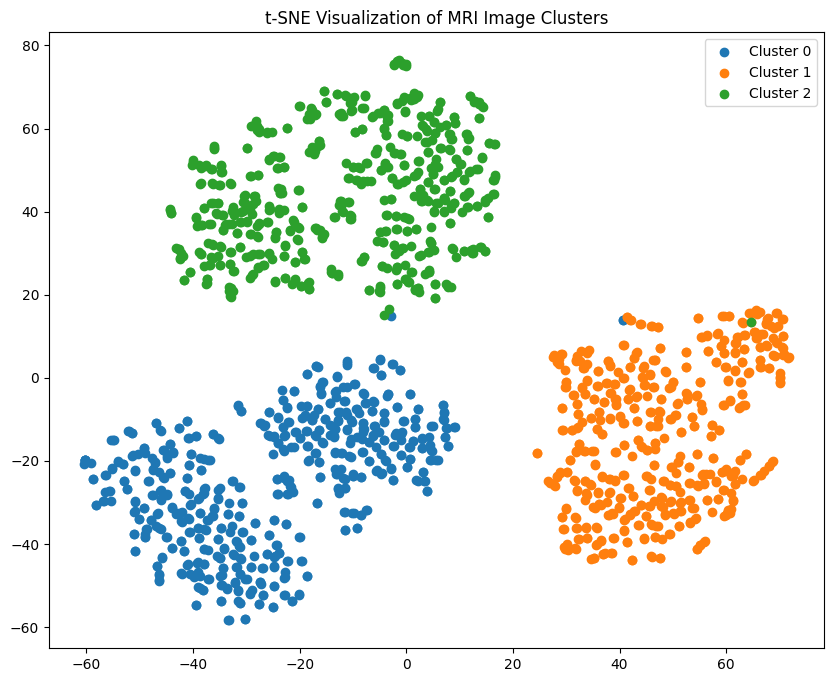

In [ ]:
plt.figure(figsize=(10, 8))
for i in range(3):
    idx = cluster_labels == i
    plt.scatter(tsne_results[idx, 0], tsne_results[idx, 1], label=f"Cluster {i}")
plt.legend()
plt.title("t-SNE Visualization of MRI Image Clusters")
plt.show()

In [ ]:
def show_cluster(cluster_id, num_samples=5):
    idxs = np.where(cluster_labels == cluster_id)[0][:num_samples]
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(idxs):
        img = Image.open(image_paths[idx])
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Cluster {cluster_id}")
        plt.axis('off')
    plt.show()

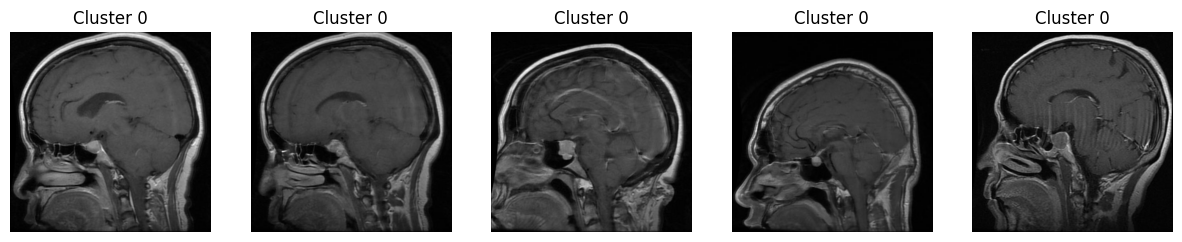

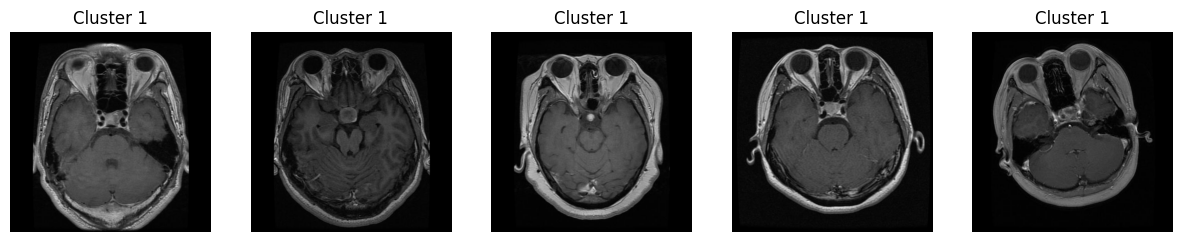

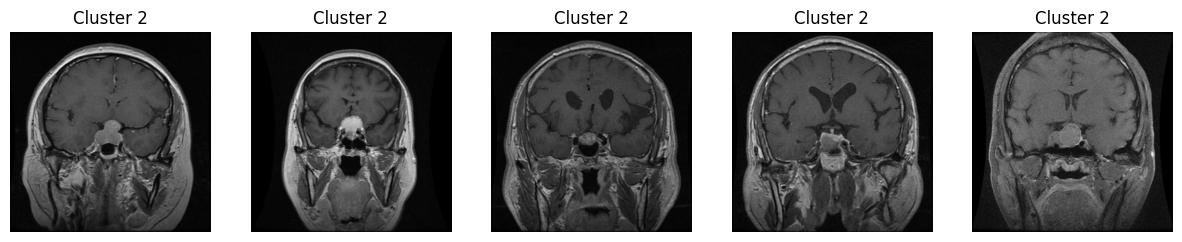

In [ ]:
for c in range(3):
    show_cluster(c)

In [ ]:
TP_cluster_df = pd.DataFrame({
    "image_path": image_paths,
    "cluster": cluster_labels
})

TP_cluster_name_map = {
    0: "sagittal",
    1: "axial",
    2: "coronal"
}
TP_cluster_df["cluster"] = TP_cluster_df["cluster"].map(TP_cluster_name_map)
TP_cluster_df.rename(columns={"cluster": "anatomical_view"}, inplace=True)

In [ ]:
TP_cluster_df

,image_path,anatomical_view
0,/content/drive/MyDrive/281_final_project/plane...,axial
1,/content/drive/MyDrive/281_final_project/plane...,coronal
2,/content/drive/MyDrive/281_final_project/plane...,coronal
3,/content/drive/MyDrive/281_final_project/plane...,sagittal
4,/content/drive/MyDrive/281_final_project/plane...,sagittal
...,...,...
1762,/content/drive/MyDrive/281_final_project/plane...,coronal
1763,/content/drive/MyDrive/281_final_project/plane...,coronal
1764,/content/drive/MyDrive/281_final_project/plane...,coronal
1765,/content/drive/MyDrive/281_final_project/plane...,coronal


In [ ]:
TP_cluster_df = TP_cluster_df.dropna(subset=["anatomical_view"]).reset_index(drop=True)

In [ ]:
TP_cluster_df.to_csv("pituitary_views_named.csv", index=False)

In [9]:
TP_cluster_df = pd.read_csv("/content/drive/MyDrive/281_final_project/pituitary_views_named.csv")

In [10]:
TP_cluster_df

,image_path,anatomical_view
0,/content/drive/MyDrive/281_final_project/plane...,axial
1,/content/drive/MyDrive/281_final_project/plane...,coronal
2,/content/drive/MyDrive/281_final_project/plane...,coronal
3,/content/drive/MyDrive/281_final_project/plane...,sagittal
4,/content/drive/MyDrive/281_final_project/plane...,sagittal
...,...,...
1762,/content/drive/MyDrive/281_final_project/plane...,coronal
1763,/content/drive/MyDrive/281_final_project/plane...,coronal
1764,/content/drive/MyDrive/281_final_project/plane...,coronal
1765,/content/drive/MyDrive/281_final_project/plane...,coronal


In [11]:
TP_cluster_name_map = {
    0: "sagittal",
    1: "axial",
    2: "coronal"
}

In [12]:
label2idx = TP_cluster_name_map
idx2label = {v: k for k, v in label2idx.items()}

print(label2idx)
print(idx2label)

TP_cluster_df["label_idx"] = (TP_cluster_df["anatomical_view"].str.lower().map(label2idx))

{0: 'sagittal', 1: 'axial', 2: 'coronal'}
{'sagittal': 0, 'axial': 1, 'coronal': 2}


In [13]:
train_df, valtest_df = train_test_split(TP_cluster_df,test_size=0.30,stratify=TP_cluster_df["anatomical_view"],random_state=42)
val_df, test_df = train_test_split(valtest_df,test_size=0.50,stratify=valtest_df["anatomical_view"],random_state=42)

print(len(train_df), len(val_df), len(test_df))

1236 265 266


In [14]:
label2idx = {lbl: i for i, lbl in enumerate(
    sorted(TP_cluster_df["anatomical_view"].unique())
)}
idx2label = {v: k for k, v in label2idx.items()}

# Add an integer column
for df in (train_df, val_df, test_df):
    df["label_idx"] = df["anatomical_view"].map(label2idx).astype("int32")


In [17]:
IMG_SIZE  = 224
BATCH_SZ  = 32
AUTO      = tf.data.AUTOTUNE

def make_dataset(df, shuffle=True, augment=False):
    # create a dataset of (path, label_idx)
    ds = tf.data.Dataset.from_tensor_slices(
        (df["image_path"].values, df["label_idx"].values)
    )
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), reshuffle_each_iteration=True)

    def decode_img(path, label):
        img = tf.io.read_file(path)
        img = tf.io.decode_jpeg(img, channels=1)
        img = tf.image.resize(img, (224, 224))
        img = tf.image.convert_image_dtype(img, tf.float32)
        img = tf.image.grayscale_to_rgb(img)
        img = preprocess_input(img)
        return img, label

    ds = ds.map(decode_img, num_parallel_calls=AUTO)

    return ds.batch(BATCH_SZ).prefetch(AUTO)


In [18]:
train_ds = make_dataset(train_df, shuffle=True,  augment=True)
val_ds   = make_dataset(val_df,   shuffle=False, augment=False)
test_ds  = make_dataset(test_df,  shuffle=False, augment=False)

In [19]:
IMG_SIZE  = 224
BATCH_SZ  = 32
AUTO      = tf.data.AUTOTUNE
def build_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=3):
    model = models.Sequential([
        layers.Conv2D(32, 3, activation='relu', padding='same',
                      input_shape=input_shape),
        layers.MaxPooling2D(),

        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),

        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_cnn()
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,938,819 (49.36 MB)

 Trainable params: 12,938,819 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
ckpt = callbacks.ModelCheckpoint(
    "best_view_cnn.h5", monitor="val_accuracy",
    save_best_only=True, verbose=1
)
early = callbacks.EarlyStopping(
    monitor="val_accuracy", patience=6, restore_best_weights=True
)

history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[ckpt, early]
)

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7120 - loss: 0.6840
Epoch 1: val_accuracy improved from -inf to 0.97358, saving model to best_view_cnn.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 226s 5s/step - accuracy: 0.7156 - loss: 0.6770 - val_accuracy: 0.9736 - val_loss: 0.0928
Epoch 2/50
38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.9810 - loss: 0.0649
Epoch 2: val_accuracy improved from 0.97358 to 0.98113, saving model to best_view_cnn.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 44s 155ms/step - accuracy: 0.9809 - loss: 0.0649 - val_accuracy: 0.9811 - val_loss: 0.0761
Epoch 3/50
38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9833 - loss: 0.0543
Epoch 3: val_accuracy improved from 0.98113 to 0.98868, saving model to best_view_cnn.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.9835 - loss: 0.0538 - val_accuracy: 0.9887 - val_loss: 0.0464
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.9965 - loss: 0.0196
Epoch 4: val_accuracy did not improve from 0.98868
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.9965 - loss: 0.0197 - val_accuracy: 0.9849 - val_loss: 0.0589
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9936 - loss: 0.0180
Epoch 5: val_accuracy did not improve from 0.98868
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9936 - loss: 0.0180 - val_accuracy: 0.9887 - val_loss: 0.0348
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9974 - loss: 0.0088
Epoch 6: val_accuracy did not improve from 0.98868
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.9974 - loss: 0.0088 - val_accuracy: 0.9887 - val_loss: 0.0442
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9990 - loss: 0.0058
Epoch 7: val_accuracy did not improve

In [21]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - accuracy: 0.9953 - loss: 0.0447
Test accuracy: 0.992


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step


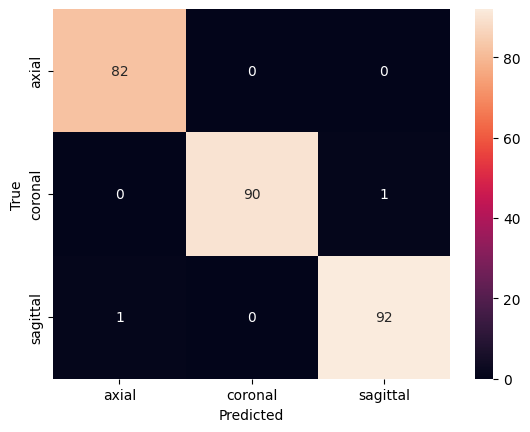

In [22]:
y_true, y_pred = [], []
for x, y in test_ds:
    y_true.extend(y.numpy())
    y_pred.extend(model.predict(x).argmax(1))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=label2idx.keys(),
            yticklabels=label2idx.keys())
plt.ylabel("True")
plt.xlabel("Predicted")
plt.show()

In [28]:
MODEL_PATH = "/content/drive/MyDrive/281_final_project/best_view_cnn.h5"

TARGET_DIRS = [
    Path("/content/drive/MyDrive/281_final_project/plane_classification_data/Training/notumor"),
    Path("/content/drive/MyDrive/281_final_project/plane_classification_data/Testing/notumor")
]

IMG_EXTS = {".jpg", ".jpeg", ".png"}
IMG_SIZE = 224
BATCH_SZ = 32
AUTO     = tf.data.AUTOTUNE

idx2label = {0: "Axial", 1: "Coronal", 2: "Sagittal"}

In [29]:
notumor_image_paths = sorted(
    str(p) for root in TARGET_DIRS
    for p in root.rglob("*")
    if p.suffix.lower() in IMG_EXTS
)

print(f"Found {len(notumor_image_paths)} images to label.")

Found 2000 images to label.


In [30]:
def preprocess(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, (224, 224))
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.grayscale_to_rgb(img)
    img = preprocess_input(img)
    return img

ds = (tf.data.Dataset.from_tensor_slices(notumor_image_paths)
      .map(preprocess, num_parallel_calls=AUTO)
      .batch(BATCH_SZ)
      .prefetch(AUTO))

In [34]:
model = tf.keras.models.load_model(MODEL_PATH)
prob = model.predict(ds, verbose=1)
pred_idx = prob.argmax(axis=1)
pred_lbl = [idx2label[i] for i in pred_idx]

63/63 ━━━━━━━━━━━━━━━━━━━━ 257s 4s/step


In [35]:
out_csv = "/content/drive/MyDrive/281_final_project/notumor_view_predictions.csv"
pd.DataFrame({
    "path": image_paths,
    "view_prediction": pred_lbl
}).to_csv(out_csv, index=False)

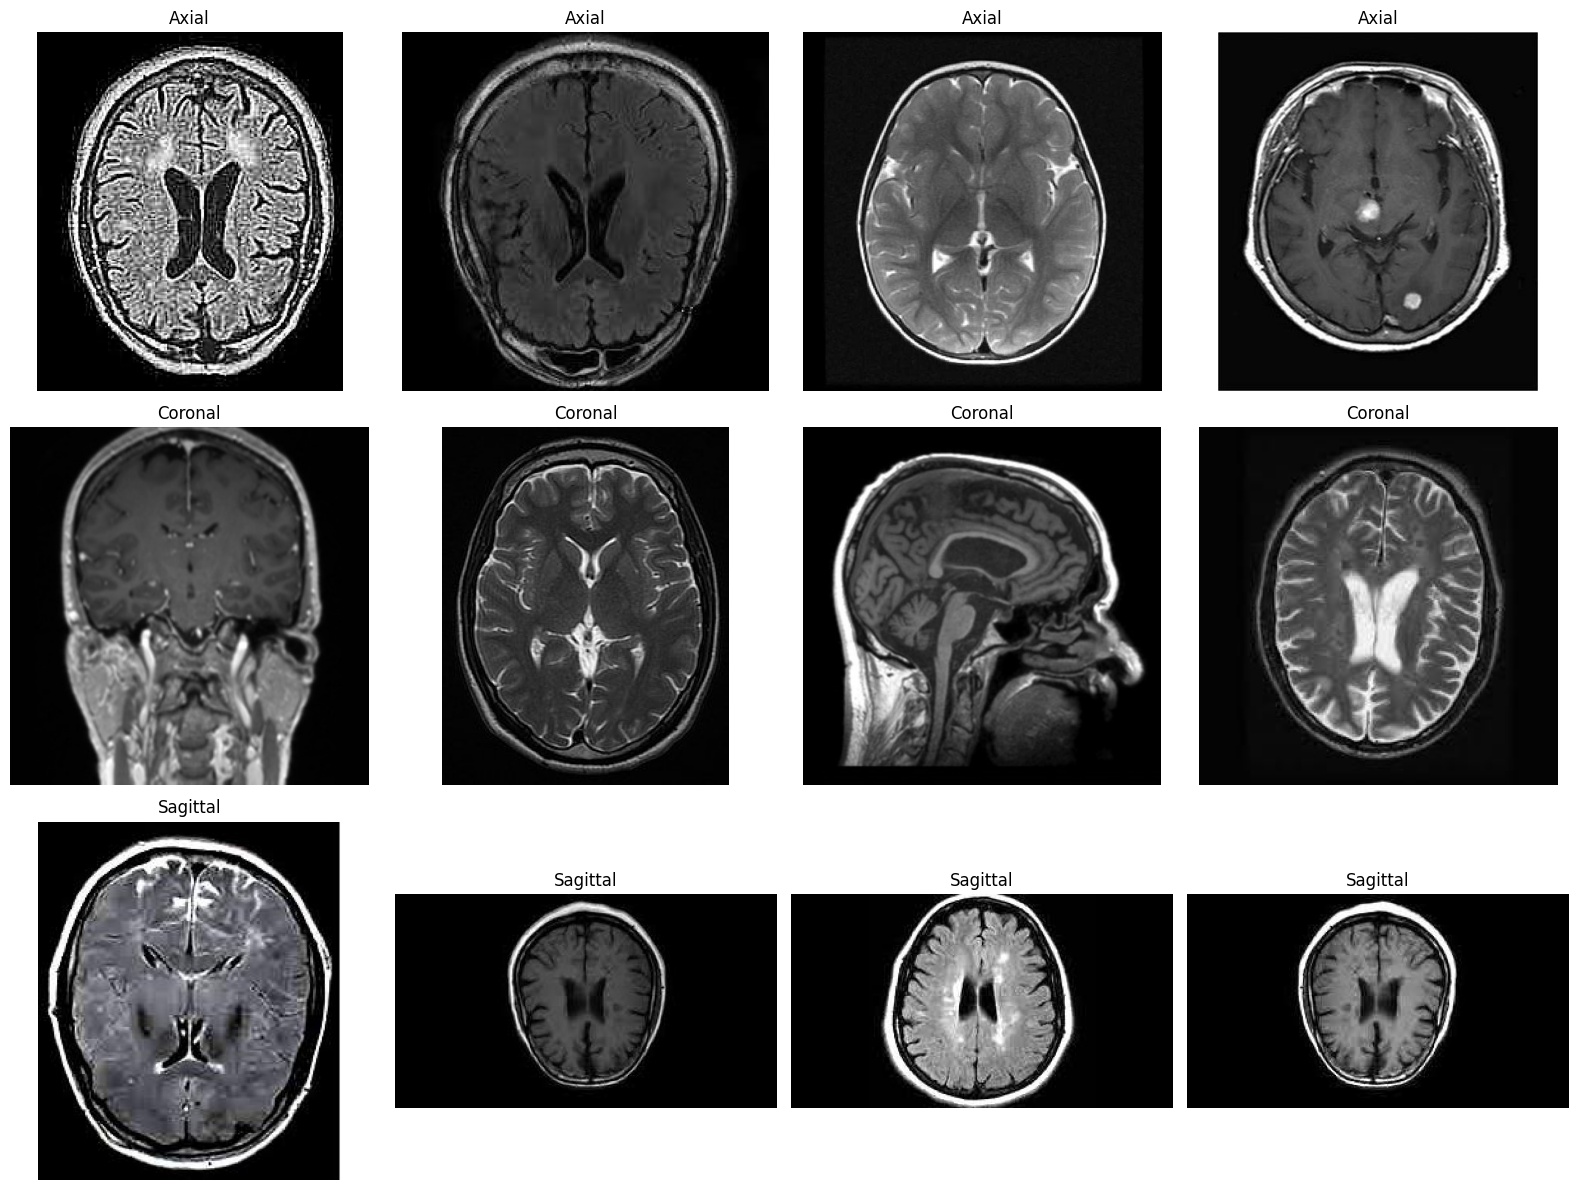

In [40]:
CSV_PATH = "/content/drive/MyDrive/281_final_project/notumor_view_predictions.csv"
df = pd.read_csv(CSV_PATH)

CLASSES = ["Axial", "Coronal", "Sagittal"]
SAMPLES_EACH  = 4


rows = []
for cls in CLASSES:
    subset = df[df["view_prediction"] == cls]
    rows.append(subset.sample(min(SAMPLES_EACH, len(subset)),
                              random_state=0))

plot_df = pd.concat(rows, ignore_index=True)

n_rows = len(rows)
n_cols = SAMPLES_EACH

plt.figure(figsize=(n_cols * 4, n_rows * 4))

for i, (path, pred) in enumerate(zip(plot_df["path"],
                                     plot_df["view_prediction"])):
    img = Image.open(path)
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(img)
    plt.title(pred)
    plt.axis("off")

plt.tight_layout()
plt.show()
